Performing grid search for KNN...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters found:
{'metric': 'cosine', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}

Best cross-validation accuracy: 0.8690

Classification report with best estimator (10-fold CV):
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       200
           1       0.90      0.69      0.78       200
           2       0.79      0.96      0.87       200
           3       0.96      0.77      0.85       200
           4       0.89      0.96      0.93       200

    accuracy                           0.87      1000
   macro avg       0.88      0.87      0.87      1000
weighted avg       0.88      0.87      0.87      1000



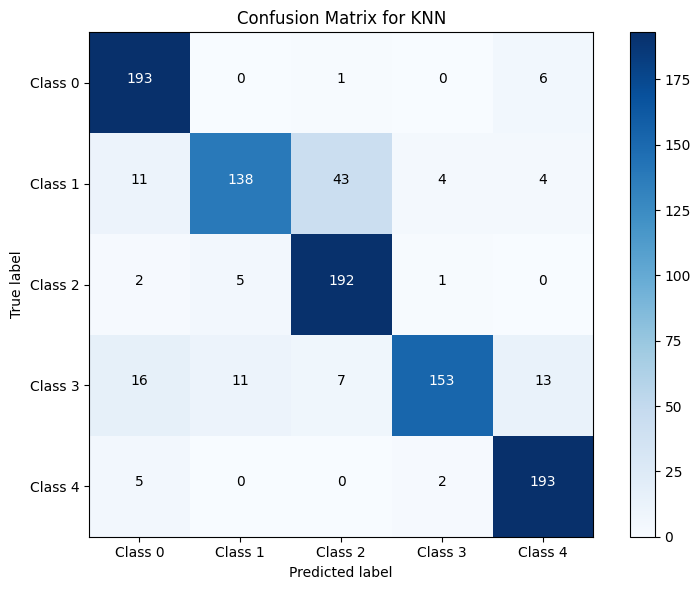

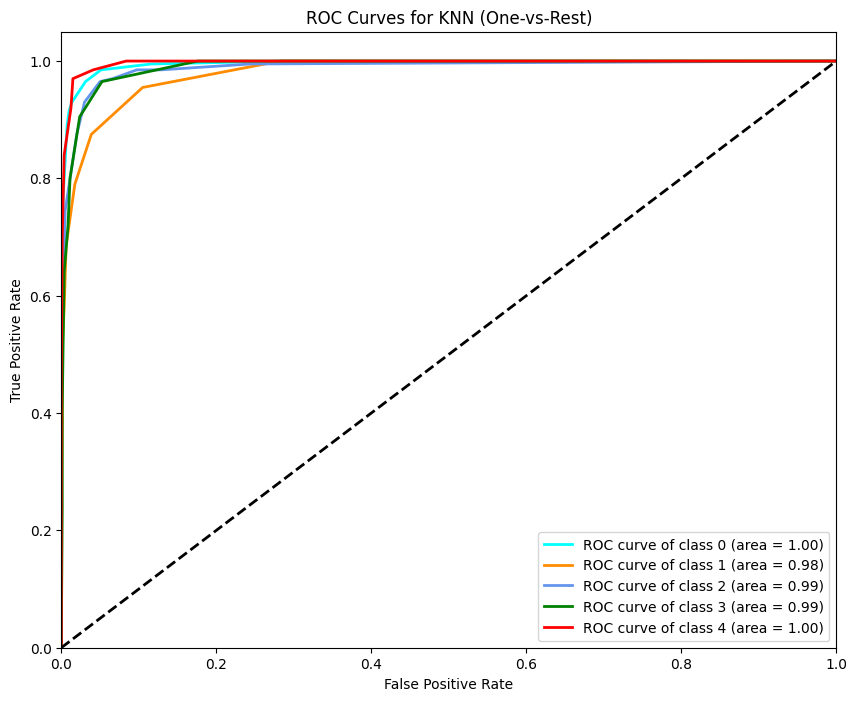


Average ROC-AUC score (One-vs-Rest): 0.9783 (±0.0058)


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import (confusion_matrix, classification_report, 
                           roc_auc_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Assuming you have your BOW features in X and labels in y
# X = your bag-of-words features (n_samples, n_features)
# y = your labels (n_samples,) with values 0-4 for 5 classes
df_tfidf = pd.read_pickle('tfi.pkl')

X = df_tfidf.drop(['num_label'], axis=1).values
y = df_tfidf['num_label'].values
classes = np.unique(y)

# Binarize the labels for ROC-AUC
y_bin = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y_bin.shape[1]

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'cosine', 'manhattan'],
    'p': [1, 2]  # For minkowski metric
}

# Create KNN classifier
knn = KNeighborsClassifier()

# Set up 10-fold cross-validated grid search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, 
                         cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

# Perform grid search
print("Performing grid search for KNN...")
grid_search.fit(X, y)

# Print best parameters and score
print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"\nBest cross-validation accuracy: {grid_search.best_score_:.4f}")

# Get the best estimator
best_knn = grid_search.best_estimator_

# Evaluate on the full dataset with cross-validation
print("\nClassification report with best estimator (10-fold CV):")
y_pred = cross_val_predict(best_knn, X, y, cv=cv)
print(classification_report(y, y_pred))

# Confusion matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN")
plt.colorbar()
tick_marks = np.arange(5)
plt.xticks(tick_marks, [f"Class {i}" for i in range(5)])
plt.yticks(tick_marks, [f"Class {i}" for i in range(5)])

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# ROC-AUC curves
plt.figure(figsize=(10, 8))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], best_knn.predict_proba(X)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), best_knn.predict_proba(X).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label='ROC curve of class {0} (area = {1:0.2f})'
            ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for KNN (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

# Print average ROC-AUC score
roc_auc_scores = []
for train, test in cv.split(X, y):
    best_knn.fit(X[train], y[train])
    y_score = best_knn.predict_proba(X[test])
    roc_auc_scores.append(roc_auc_score(y_bin[test], y_score, multi_class='ovr'))

print(f"\nAverage ROC-AUC score (One-vs-Rest): {np.mean(roc_auc_scores):.4f} (±{np.std(roc_auc_scores):.4f})")